# Dynamic Optimization with Pyomo.DAE: An Example
**Prepared by:** Prof. Alexander Dowling, Molly Dougher (mdoughe6@nd.edu, 2023)

In [ ]:
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py"
    import helper
    #!pip install casadi
    helper.install_idaes()
    helper.install_ipopt()

--2023-05-04 21:36:24--  https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7171 (7.0K) [text/plain]
Saving to: ‘helper.py’


helper.py             0%[                    ]       0  --.-KB/s               
helper.py           100%[===================>]   7.00K  --.-KB/s    in 0s      

2023-05-04 21:36:24 (53.9 MB/s) - ‘helper.py’ saved [7171/7171]

Installing idaes via pip...
idaes was successfully installed
Running idaes get-extensions to install Ipopt, k_aug, and more...
Ipopt 3.13.2 (x86_64-pc-linux-gnu), ASL(20190605)

[K_AUG] 0.1.0, Part of the IDAES PSE framework
Please visit https://idaes.org/ (x86_64-pc-linux-gnu), ASL(20190605)

Couenne 0.5.8 -- an Open-Source solver for Mixed I

## Car Example

Adapted from https://github.com/Pyomo/pyomo/blob/master/examples/dae/car_example.py

You are a race car driver with a simple goal. Drive distance $L$ in the minimal amount of time **but** come to a complete stop at the finish line.

### Optimal Control Problem Formulation

Mathematically, you want to solve the following optimal control problem:

$$\begin{align*}
\min_{u} \quad & t_f \\
\mathrm{s.t.} \quad & \frac{dx}{dt} = v \\
& \frac{dv}{dt} = u - R v^2 \\
& x(t=0) = 0, ~~ x(t=t_f) = L \\
& v(t=0) = 0, ~~ v(t=t_f) = 0 \\
& -3 \leq u \leq 1
\end{align*}$$

where $a$ is the acceleration/braking (your control variable) and $R$ is the drag coefficient (parameter).

### Scale Time

Let $t = \tau \cdot t_f$ where $\tau \in [0,1]$. Thus $dt = t_f d\tau$. The optimal control problem becomes:

$$\begin{align*}
\min_{u} \quad & t_f \\
\mathrm{s.t.} \quad & \frac{dx}{d\tau} = t_f v \\
& \frac{dv}{d\tau} = t_f (u - R v^2) \\
& x(\tau = 0) = 0, ~~ x(\tau = 1) = L \\
& v(\tau = 0) = 0, ~~ v(\tau = 1) = 0 \\
& -3 \leq u \leq 1
\end{align*}$$

### Orthogonal Collocation on Finite Elements: Manual Approach

Here is the "classical"/"old school" way of manually implementing collocation on finite elements with sets.

**Indices and Sets**
* Finite elements: $i \in \mathcal{I} = \{1,2,...,N_{FE}\}$
* Finite elements (except first): $\mathcal{I} \setminus 1$
* Internal collocation points: $j,k \in \mathcal{J} = \{1,2,...,N_{C}\}$


**Parameters**
* Coefficients in collocation/Runge-Kutta formula: $a_{j,j}$
* Drag coefficient: $R$
* Race length: $L$
* Scaled time for each finite element: $h_i = \frac{1}{N_{FE}}$

**Variables**
* Position (internal collocation points): $x_{i,j}$
* Position (beginning of each finite element): $\bar{x}_{i}$
* Position derivative (internal collocation points): $\dot{x}_{i,j}$
* Velocity (internal collocation points): $v_{i,j}$
* Velocity (beginning of each finite element): $\bar{v}_{i}$
* Velocity derivative (internal collocation points): $\dot{v}_{i,j}$
* Time (internal collocation points): $t_{i,j}$
* Time (beginning of each finite element): $\bar{t}_{i}$
* Acceleration (control degrees of freedom): $u_i$

**Objective and Constraints**

$$\begin{align*}
\min \quad & t_f \\
\mathrm{s.t.} \quad & \mathrm{Differential~equation~for~x:} \\ 
& x_{i,j} = \bar{x}_{i} + h_i \sum_{k \in \mathcal{J}} a_{k,j} \dot{x}_{i,k},\quad \forall i \in \mathcal{I},~j \in \mathcal{J} \\
& \bar{x}_{i} = \bar{x}_{i-1} + h_{i-1} \sum_{k \in \mathcal{J}} a_{k,N_C} \dot{x}_{i-1,k},\quad \forall i \in \mathcal{I} \setminus 1\\
& \dot{x}_{i,j} = t_f v_{i,j}, \quad \forall i \in \mathcal{I} \setminus 1,~j \in \mathcal{J} \\ \\
& \mathrm{Differential~equation~for~v:} \\ 
& v_{i,j} = \bar{v}_{i} + h_i \sum_{k \in \mathcal{J}} a_{k,j} \dot{v}_{i,k},\quad \forall i \in \mathcal{I},~j \in \mathcal{J} \\
& \bar{v}_{i} = \bar{v}_{i-1} + h_{i-1} \sum_{k \in \mathcal{J}} a_{k,N_C} \dot{v}_{i-1,k},\quad \forall i \in \mathcal{I} \setminus 1\\
& \dot{v}_{i,j} = t_f (u_{i} - R v_{i,j}^2), \quad \forall i \in \mathcal{I} \setminus 1,~j \in \mathcal{J} \\ \\
& \mathrm{Differential~equation~for~time:} \\
& t_{i,j} = \bar{t}_{i} + h_i \sum_{k \in \mathcal{J}} a_{k,j} t_f,\quad \forall i \in \mathcal{I},~j \in \mathcal{J} \\
& \bar{t}_{i} = \bar{t}_{i-1} + h_{i-1} \sum_{k \in \mathcal{J}} a_{k,N_C} t_f,\quad \forall i \in \mathcal{I} \setminus 1\\ \\
& \mathrm{Initial~conditions:} \\ 
& \bar{x}_{1} = 0, \quad \bar{v}_{1} = 0, \quad \bar{t}_1 = 0\\ \\
& \mathrm{Boundary~conditions:} \\ 
& L = \bar{x}_{N_{FE}} + h_{N_{FE}} \sum_{k \in \mathcal{J}} a_{k,N_C} \dot{x}_{N_{FE},k}, \\
& 0 = \bar{v}_{N_{FE}} + h_{N_{FE}} \sum_{k \in \mathcal{J}} a_{k,N_C} \dot{v}_{N_{FE},k}, \\ \\
& \mathrm{Bounds~on~acceleration:} \\
& -3 \leq a_i \leq 1, \quad \forall i \in \mathcal{I}
\end{align*}$$

In [ ]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import pyomo.dae as dae

# Define the model
m2 = pyo.ConcreteModel()

# Define model parameters
m2.R = pyo.Param(initialize=0.001) # Friction factor
m2.L = pyo.Param(initialize=100.0) # Final position

# Define finite elements and collocation points
NFE = 15  # Number of finite elements
NC = 3    # Number of collocation points
m2.I = pyo.Set(initialize=pyo.RangeSet(1,NFE)) # Set of finite elements
m2.J = pyo.Set(initialize=pyo.RangeSet(1,NC)) # Set of internal collocation points

# Define first order derivative collocation matrix
A = {}
A[1,1] = 0.19681547722366
A[1,2] = 0.39442431473909
A[1,3] = 0.37640306270047
A[2,1] = -0.06553542585020
A[2,2] = 0.29207341166523
A[2,3] = 0.51248582618842
A[3,1] = 0.02377097434822
A[3,2] = -0.04154875212600
A[3,3] = 0.11111111111111

# Define A matrix as a model parameter
m2.a = pyo.Param(m2.J, m2.J, initialize=A)

# Define step for each finite element
m2.h = pyo.Param(m2.I,initialize=1/NFE)

# Define objective (final time)
m2.tf = pyo.Var(domain=pyo.NonNegativeReals)

# Variables for x (position)
m2.x0 = pyo.Var(m2.I)         # Internal collocation points
m2.x = pyo.Var(m2.I,m2.J)     # Beginning of each finite element
m2.xdot = pyo.Var(m2.I,m2.J)  # Derivative, beginning of each finite element

# Variables for v (velocity)
m2.v0 = pyo.Var(m2.I)         # Internal collocation points
m2.v = pyo.Var(m2.I,m2.J)     # Beginning of each finite element
m2.vdot = pyo.Var(m2.I,m2.J)  # Derivative, beginning of each finite element

# Variables for t
m2.t0 = pyo.Var(m2.I)         # Internal collocation points
m2.t = pyo.Var(m2.I,m2.J)     # Beginning of each finite element

# Acceleration
m2.u = pyo.Var(m2.I, bounds=(-3,1))   # Control DOF

### Finite Element Collocation Equations
# position
def FECOLx_(m2,i,j):
    return m2.x[i,j] == m2.x0[i] + m2.h[i]*sum(m2.a[k,j]*m2.xdot[i,k] for k in m2.J)
m2.FECOLx = pyo.Constraint(m2.I,m2.J,rule=FECOLx_)

# velocity
def FECOLv_(m2,i,j):
    return m2.v[i,j] == m2.v0[i] + m2.h[i]*sum(m2.a[k,j]*m2.vdot[i,k] for k in m2.J)
m2.FECOLv = pyo.Constraint(m2.I,m2.J,rule=FECOLv_)

# time
def FECOLt_(m2,i,j):
    return m2.t[i,j] == m2.t0[i] + m2.h[i]*sum(m2.a[k,j]*m2.tf for k in m2.J)
m2.FECOLt = pyo.Constraint(m2.I,m2.J,rule=FECOLt_)


### Continuity Equations
# position
def CONx_(m2,i):
    if i == 1:
        return pyo.Constraint.Skip
    else:
        return m2.x0[i] == m2.x0[i-1] + m2.h[i-1]*sum(m2.a[k,NC]*m2.xdot[i,k] for k in m2.J)
m2.CONx = pyo.Constraint(m2.I, rule=CONx_)

# velocity
def CONv_(m2,i):
    if i == 1:
        return pyo.Constraint.Skip
    else:
        return m2.v0[i] == m2.v0[i-1] + m2.h[i-1]*sum(m2.a[k,NC]*m2.vdot[i,k] for k in m2.J)
m2.CONv = pyo.Constraint(m2.I, rule=CONv_)

# time
def CONt_(m2,i):
    if i == 1:
        return pyo.Constraint.Skip
    else:
        return m2.t0[i] == m2.t0[i-1] + m2.h[i-1]*sum(m2.a[k,NC]*m2.tf for k in m2.J)
m2.CONt = pyo.Constraint(m2.I, rule=CONt_)

### Differential equations
# position
def ODEx_(m2,i,j):
    return m2.xdot[i,j] == m2.tf*m2.v[i,j]
m2.ODEx = pyo.Constraint(m2.I,m2.J,rule=ODEx_)

# velocity
def ODEv_(m2,i,j):
    return m2.vdot[i,j] == m2.tf*(m2.u[i] - m2.R*m2.v[i,j]**2)
m2.ODEv = pyo.Constraint(m2.I,m2.J,rule=ODEv_)

### Initial conditions
m2.xIC = pyo.Constraint(expr=m2.x0[1] == 0)
m2.vIC = pyo.Constraint(expr=m2.v0[1] == 0)
m2.tIC = pyo.Constraint(expr=m2.t0[1] == 0)

### Boundary conditions
m2.xBC = pyo.Constraint(expr=m2.L == m2.x0[NFE] + m2.h[NFE]*sum(m2.a[k,NC]*m2.xdot[NFE,k] for k in m2.J))
m2.vBC = pyo.Constraint(expr=0 == m2.v0[NFE] + m2.h[NFE]*sum(m2.a[k,NC]*m2.vdot[NFE,k] for k in m2.J))

### Set objective
m2.obj = pyo.Objective(expr=m2.tf)

In [ ]:
# Solve the model
solver = pyo.SolverFactory('ipopt')
solver.solve(m2,tee=True)

print("final time = %6.2f" %(pyo.value(m2.tf)))

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

### Orthogonal Collocation on Finite Elements: Pyomo.dae

There is a better way! We can use `Pyomo.dae` to automatically formulate the collocation equations.

#### Declare Model

In [ ]:
# Define the  model
m = pyo.ConcreteModel()

# Deine the model parameters
m.R = pyo.Param(initialize=0.001) # Friction factor
m.L = pyo.Param(initialize=100.0) # Final position

# Define time
m.tau = dae.ContinuousSet(bounds=(0,1)) # Unscaled time
m.time = pyo.Var(m.tau)                 # Scaled time
m.tf = pyo.Var()                        # Final time

# Define remaining algebraic variables
m.x = pyo.Var(m.tau,bounds=(0,m.L+50))                # Position
m.v = pyo.Var(m.tau,bounds=(0,None))                  # Velocity
m.u = pyo.Var(m.tau, bounds=(-3.0,1.0),initialize=0)  # Acceleration

# Define derivative variables
m.dtime = dae.DerivativeVar(m.time)
m.dx = dae.DerivativeVar(m.x)
m.dv = dae.DerivativeVar(m.v)

# Declare the objective (minimize final time)
m.obj = pyo.Objective(expr=m.tf)

# Define the constraints
# position
def _ode1(m,i):
    if i == 0 :
        return pyo.Constraint.Skip
    return m.dx[i] == m.tf * m.v[i]
m.ode1 = pyo.Constraint(m.tau, rule=_ode1)

# velocity
def _ode2(m,i):
    if i == 0 :
        return pyo.Constraint.Skip
    return m.dv[i] == m.tf*(m.u[i] - m.R*m.v[i]**2)
m.ode2 = pyo.Constraint(m.tau, rule=_ode2)

# time
def _ode3(m,i):
    if i == 0:
        return pyo.Constraint.Skip
    return m.dtime[i] == m.tf
m.ode3 = pyo.Constraint(m.tau, rule=_ode3)

# Define the inital/boundary conditions
def _init(m):
    yield m.x[0] == 0
    yield m.x[1] == m.L
    yield m.v[0] == 0
    yield m.v[1] == 0
    yield m.time[0] == 0
    
m.initcon = pyo.ConstraintList(rule=_init)

#### Discretize/Transcribe and Solve

In [ ]:
#discretizer = TransformationFactory('dae.finite_difference')
#discretizer.apply_to(m,nfe=15,scheme='BACKWARD')

# Declare the discretizer
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(m,nfe=15,scheme='LAGRANGE-RADAU',ncp=3)
#discretizer.apply_to(m,nfe=15,scheme='LAGRANGE-LEGENDRE',ncp=3)

# force piecewise constant controls (acceleration) over each finite element
m = discretizer.reduce_collocation_points(m,var=m.u,ncp=1,contset=m.tau)

# Solve
solver = pyo.SolverFactory('ipopt')
solver.solve(m,tee=True)

print("final time = %6.2f" %(pyo.value(m.tf)))

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

#### Plot Results

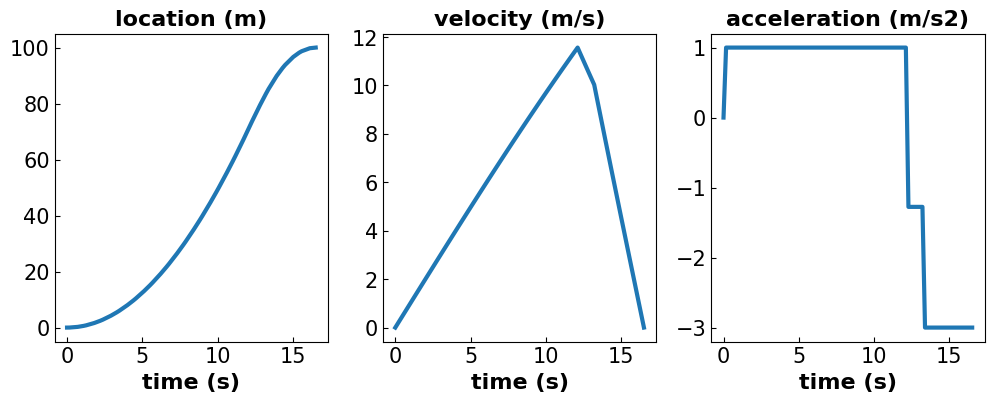

In [ ]:
# Define empty lists
x = []    # position, units of length
v = []    # velocity, units of length per time
u = []    # acceleration, units of length per time squared
time=[]   # time

# Loop over time and append the solution values for each variable to their respective lists
for i in m.tau:
    time.append(pyo.value(m.time[i]))
    x.append(pyo.value(m.x[i]))
    v.append(pyo.value(m.v[i]))
    u.append(pyo.value(m.u[i]))

# Make a figure
plt.figure(figsize=(12,4))

# Format subplot 1 (position)    
plt.subplot(131)
plt.plot(time,x,linewidth=3,label='x')
plt.title('location (m)',fontsize=16, fontweight='bold')
plt.xlabel('time (s)',fontsize=16, fontweight='bold')
plt.tick_params(direction="in",labelsize=15)

# Format subplot 2 (velocity)
plt.subplot(132)
plt.plot(time,v,linewidth=3,label='v')
plt.xlabel('time (s)',fontsize=16, fontweight='bold')
plt.title('velocity (m/s)',fontsize=16, fontweight='bold')
plt.tick_params(direction="in",labelsize=15)

# Format subplot 3 (acceleration)
plt.subplot(133)
plt.plot(time,u,linewidth=3,label='a')
plt.xlabel('time (s)',fontsize=16, fontweight='bold')
plt.title('acceleration (m/s2)',fontsize=16, fontweight='bold')
plt.tick_params(direction="in",labelsize=15)

plt.show()

**Discussion Questions**

1. How does the time/number of evaluations that IPOPT needs to solve the problem change for a discretized versus non-discretized model?
2. Why might the two solutions differ?
3. Check to make sure that these results make sense. Based on the known derivative relationships between position, velocity, and acceleration, do the 3 plots make sense? Hint: Match up the trends in each graph.